In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar4=pd.read_csv('Solar 4.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar4['datetime']=pd.to_datetime(solar4['datetime'], format='%Y-%m-%d %H:%M:%S')
solar4= solar4.set_index('datetime')
solar4= solar4.asfreq('H')

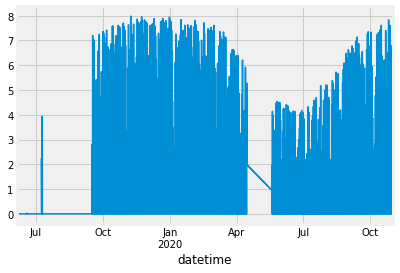

In [4]:
solar4['series_value'].plot()

In [7]:
#Split Train-Val for Solar4
# ==============================================================================
start_train='2019-10-10 00:00'
end_train='2020-04-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-08-01 00:00'
start_test='2020-08-01 01:00'

solar4train=solar4.loc[start_train:end_train, :]
solar4val=solar4.loc[start_val:end_val, :]
solar4test=solar4.loc[start_test:, :]

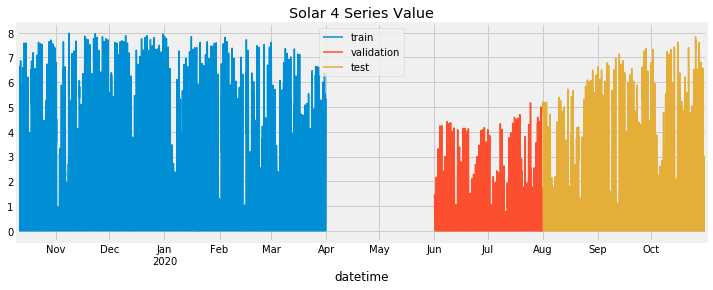

In [8]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar4train['series_value'].plot(ax=ax, label='train')
solar4val['series_value'].plot(ax=ax, label='validation')
solar4test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 4 Series Value')
ax.legend();

In [9]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:15:34 
Last fit date: None 
Skforecast version: 0.4.3 

In [11]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar4.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar4train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:10,  1.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:11,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:05,  1.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:04,  1.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:11<00:02,  1.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:12<00:01,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.31s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:10,  1.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:11,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:09,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:09,  1.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:07,  1.41s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.31s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:13<00:02,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:11,  1.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:11,  1.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:06,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:03,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:11<00:02,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:01,  1.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:58<00:00, 14.72s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.0531764893983764



In [12]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
39                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
37                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
15  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.053176   
39  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.142488   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.154721   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.163429   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.168043   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.170483   
37  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.181958   
13  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.235247   
3   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.249055   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  1.251850   

    learning_rate  max_depth  n_estimators  
15           0.01        5.0         500.0  
39           0.01        5.0         500.0  
30           0.10        3.0         100.0  
20           0.10        5.0         100.0  
21           0.10        5.0         500.0  
32           0.10        5.0         100.0  
37           0.01        3.0         500.0  
13           0.01        3.0         500.0  
3            0.01        5.0         500.0  
22           0.10       10.0         100.0

In [13]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar4['series_value'],
    initial_train_size = len(solar4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 0.9969106613398084


In [14]:
# Predictions
# ==============================================================================
predictions

pred
2020-08-01 01:00:00  3.090576
2020-08-01 02:00:00  3.385250
2020-08-01 03:00:00  3.718918
2020-08-01 04:00:00  3.221199
2020-08-01 05:00:00  1.755043
...                       ...
2020-10-31 19:00:00  0.027535
2020-10-31 20:00:00  0.480965
2020-10-31 21:00:00  1.507955
2020-10-31 22:00:00  2.385099
2020-10-31 23:00:00  2.783605

[2207 rows x 1 columns]

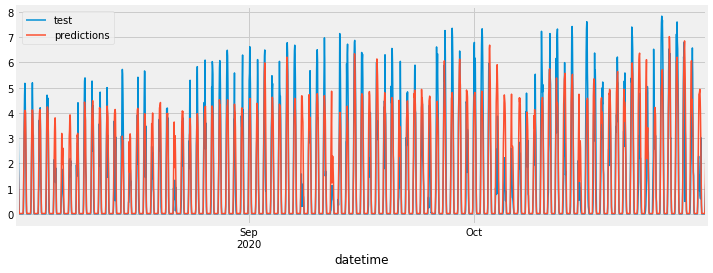

In [15]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar4test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [16]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [17]:
solar4test=solar4test.dropna()
solar4train=solar4train.dropna()

In [19]:
LGBM_Mase=mean_absolute_scaled_error(solar4test.reset_index()['series_value'],predictions.reset_index()['pred'],solar4train.reset_index()['series_value'])

In [20]:
# CatBoost Forecasting
# ==============================================================================

In [21]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x0000019ED631ABE0> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-25 01:31:41 
Last fit date: None 
Skforecast version: 0.4.3 

In [22]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = solar4.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar4train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:12<02:16, 12.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:31<02:45, 16.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:59<03:12, 21.41s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [01:47<04:15, 32.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [03:17<06:11, 53.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [06:32<10:08, 101.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [07:23<07:04, 84.95s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [08:13<04:54, 73.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [09:07<03:22, 67.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [10:12<02:13, 66.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [11:44<01:14, 74.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [01:21<14:56, 81.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [02:54<14:43, 88.37s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [04:26<13:28, 89.86s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [06:07<12:35, 94.44s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [08:35<13:15, 113.71s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [14:36<19:46, 197.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [16:23<14:00, 168.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [18:36<10:28, 157.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [20:55<07:33, 151.19s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [23:24<05:01, 150.56s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|████████████████████████████████   | 11/12 [26:41<02:44, 164.89s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                 | 1/12 [02:54<32:02, 174.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████                              | 2/12 [06:12<31:21, 188.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████                           | 3/12 [09:09<27:28, 183.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [12:25<25:05, 188.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [16:38<24:42, 211.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [25:55<32:53, 328.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [29:20<24:02, 288.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [33:33<18:28, 277.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [43:39<18:59, 379.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [54:54<15:41, 470.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|██████████████████████████████▎  | 11/12 [1:05:53<08:48, 528.60s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|██▊                               | 1/12 [09:11<1:41:01, 551.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|█████▋                            | 2/12 [17:39<1:27:42, 526.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|████████▌                         | 3/12 [23:49<1:08:10, 454.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [30:58<59:15, 444.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [38:42<52:40, 451.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [46:38<46:00, 460.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [53:33<37:06, 445.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|██████████████████████▋           | 8/12 [1:00:19<28:51, 432.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|█████████████████████████▌        | 9/12 [1:06:47<20:56, 418.75s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|███████████████████████████▌     | 10/12 [1:13:20<13:41, 410.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|██████████████████████████████▎  | 11/12 [1:20:04<06:48, 408.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████| 4/4 [3:36:38<00:00, 3249.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.9371809113366751



In [23]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = solar4['series_value'],
    initial_train_size = len(solar4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 0.9333650366808107


In [24]:
CatBoost_MASE=mean_absolute_scaled_error(solar4test.reset_index()['series_value'],cat_predictions.reset_index()['pred'],solar4train.reset_index()['series_value'])

In [25]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [26]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = solar4.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar4train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:22,  7.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:16<01:21,  8.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:23<01:10,  7.85s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:33<01:08,  8.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:41<00:58,  8.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:55<01:01, 10.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:02<00:46,  9.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:10<00:35,  8.91s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:17<00:25,  8.44s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:27<00:17,  8.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:35<00:08,  8.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:20,  7.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:16<01:23,  8.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:23<01:11,  8.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:35<01:13,  9.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:43<01:02,  8.97s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:00<01:09, 11.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:07<00:50, 10.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:16<00:39,  9.84s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:24<00:27,  9.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:35<00:19,  9.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:43<00:09,  9.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:24,  7.70s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:17<01:29,  8.93s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:25<01:15,  8.44s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:37<01:19,  9.91s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:46<01:07,  9.57s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:05<01:16, 12.71s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:12<00:54, 10.95s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:22<00:42, 10.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:29<00:28,  9.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:41<00:20, 10.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:50<00:09,  9.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:06<01:12,  6.60s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:13<01:06,  6.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:19<00:57,  6.44s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:26<00:53,  6.66s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:33<00:46,  6.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:41<00:44,  7.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:47<00:34,  6.92s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:54<00:27,  6.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:00<00:19,  6.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:07<00:13,  6.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:14<00:06,  6.66s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [07:02<00:00, 105.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 1.0929987328937678



In [27]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = solar4['series_value'],
    initial_train_size = len(solar4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 0.9964033096166582


In [28]:
XGB_MASE=mean_absolute_scaled_error(solar4test.reset_index()['series_value'],XGB_predictions.reset_index()['pred'],solar4train.reset_index()['series_value'])

In [29]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('s4_actual_additive.csv')

In [30]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [31]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test:, :]

In [32]:
prophet=prophet.dropna()

In [33]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:08,  1.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:08,  1.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:07,  1.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:07,  1.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:08,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:02,  1.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:00,  1.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:07,  1.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:09,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:10,  1.69s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:08,  1.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:11,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:12,  1.54s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:10,  1.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:09<00:12,  2.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:10<00:08,  1.63s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:11<00:06,  1.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:12<00:03,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:14<00:02,  1.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:15<00:01,  1.37s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:07,  1.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:06,  1.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:07,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:05,  1.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:06,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:06<00:04,  1.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:07<00:03,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:07<00:02,  1.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:08<00:01,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:09<00:00,  1.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:58<00:00, 14.64s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.7468209316116459



In [34]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
24  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
38                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
36                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
26  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
0   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
40                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
4   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
12  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  0.746821   
24  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  0.747775   
38  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  0.769549   
36  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  0.779506   
26  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  0.839533   
16  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  0.845222   
0   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  0.851712   
40  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  0.858478   
4   {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  0.903923   
14  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  0.905477   

    learning_rate  max_depth  n_estimators  
12           0.01        3.0         100.0  
24           0.01        3.0         100.0  
38           0.01        5.0         100.0  
36           0.01        3.0         100.0  
26           0.01        5.0         100.0  
16           0.01       10.0         100.0  
0            0.01        3.0         100.0  
40           0.01       10.0         100.0  
4            0.01       10.0         100.0  
14           0.01        5.0         100.0

In [35]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 1.2802140684880454


In [36]:
# Predictions
# ==============================================================================
prophet_predictions

pred
2020-08-01 01:00:00  0.889566
2020-08-01 02:00:00  1.097102
2020-08-01 03:00:00  1.100385
2020-08-01 04:00:00  1.022156
2020-08-01 05:00:00  1.022156
...                       ...
2020-10-31 19:00:00  1.022156
2020-10-31 20:00:00  1.022156
2020-10-31 21:00:00  1.069333
2020-10-31 22:00:00  1.022156
2020-10-31 23:00:00  0.971463

[2207 rows x 1 columns]

In [37]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [38]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [39]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [40]:
LightGBM_Prophet_MASE

2.595510792101519

In [41]:
LGBM_Mase

0.8724755617678419

In [42]:
CatBoost_MASE

0.8524618363155401

In [43]:
XGB_MASE

0.853973688681366